You will take MS COCO captions for two or more COCO categories and train a word-based LSTM model with two distinct outputs: predicting the next plausible word as well as a distribution over categories. In other words, you will look up the captions in COCO, use their identifiers to look up other other categories associated with their image (requiring the modification of mycoco.py...), and then train a model that simultaneously predicts the next word in the caption and the next set of categories.

HINT: You will probably need to initially train a language model on the the entire COCO caption set, and then retrain it on the specific captions you are looking at, as well as use a vector of sigmoid activations rather than a softmax for multi-class classification. 

e.g., That means when you enter "A man standing on top of a ..." the model will predict a distribution over the next possible words, with the highest probability (think softmax) word being the next word, for example "stool".  Then the categories will be a set of sigmoid-output "scores" (these will not sum to 1) over the entire category set, which you can rank in order of "confidence" of category membership.

In [1]:
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

Using TensorFlow backend.
/Users/stefan/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
captions = ['two people riding horses on a sand road ',
 'Two men ride animals on the way to a desert town.',
 'A man riding a donkey down a hill on a road.',
 'Two men ride horses through a desert area',
 'Two men ride horses on a dirt road.']

tokenizer = Tokenizer()
tokenizer.fit_on_texts(["\n".join(captions)])
encoded = tokenizer.texts_to_sequences(captions)

# The words before the words we are trying to predict
seqs = []
# The word we are trying to predict
preds = []
for e in encoded:
    # If we want to use a nested structure instead, append to this then append to seqs
    #s = []
    #p = []
    for i in range(1,len(e)):        
        end_index = len(e) - i
        seqs.append(e[:end_index])
        preds.append(e[-i])
    #seqs.append(s)
    #preds.append(p)

# Make all sequences same length by adding 0 to end
X = pad_sequences(seqs, padding='post')
input_length = len(X[0])
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
y = to_categorical(preds, num_classes=vocab_size)
# pad_sequences(encoded, padding='post')

model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=input_length))
model.add(LSTM(50))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=500, verbose=2)

Vocabulary Size: 24
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 10)            240       
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                12200     
_________________________________________________________________
dense_1 (Dense)              (None, 24)                1224      
Total params: 13,664
Trainable params: 13,664
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
 - 1s - loss: 3.1797 - acc: 0.0488
Epoch 2/500
 - 0s - loss: 3.1754 - acc: 0.1707
Epoch 3/500
 - 0s - loss: 3.1720 - acc: 0.1707
Epoch 4/500
 - 0s - loss: 3.1684 - acc: 0.1707
Epoch 5/500
 - 0s - loss: 3.1649 - acc: 0.1707
Epoch 6/500
 - 0s - loss: 3.1613 - acc: 0.1707
Epoch 7/500
 - 0s - loss: 3.1570 - acc: 0.1707
Epoch 8/500
 - 0s - loss: 3.1531 - acc: 0.1707
E

KeyboardInterrupt: 

In [57]:
captions

['two people riding horses on a sand road ',
 'Two men ride animals on the way to a desert town.',
 'A man riding a donkey down a hill on a road.',
 'Two men ride horses through a desert area',
 'Two men ride horses on a dirt road.']

In [101]:
predict_text = ['two', 'Two men riding horses on the way to',]
encoded = tokenizer.texts_to_sequences(predict_text)
print(encoded)
pred_x = pad_sequences(encoded, padding='post', maxlen=input_length)
print(pred_x)
yhat = model.predict_classes(pred_x, verbose=0)
yhat

# Access the actual word that we are predicting
word_index_inv = {v: k for k, v in tokenizer.word_index.items()}
[word_index_inv[y] for y in yhat]

[[2], [2, 6, 8, 4, 3, 13, 14, 15]]
[[ 2  0  0  0  0  0  0  0  0  0]
 [ 2  6  8  4  3 13 14 15  0  0]]


['men', 'road']

In [3]:
import numpy as np
from numpy import array
from keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Embedding, Input, concatenate

In [50]:
import pickle

with open('./horse_dog_sample.pickle', 'rb') as f:
    sample = pickle.load(f)

captions = []
categories = []
for c in sample:
    captions.append(c['caption'])
    categories.append(c['categories'])

# May need to set some max length here
tokenizer = Tokenizer()
tokenizer.fit_on_texts(["\n".join(captions)])
encoded = tokenizer.texts_to_sequences(captions)
encoded

seqs = []
# The word we are trying to predict
preds = []
# The new categories, in one-hot format
y_categories = []
for e, c in zip(encoded, categories):
    # Reindex the categories from 0 to 89 instead of 1 to 90
    # This is the format to_categorical expects
    c = np.array(c) - 1
    # Sum each of the one-hot vectors into a joined vector
    new_cat = to_categorical(cats, num_classes=90).sum(axis=0)
    for i in range(1,len(e)):        
        end_index = len(e) - i
        seqs.append(e[:end_index])
        preds.append(e[-i])
        # Just add the same category over and over
        y_categories.append(new_cat)
y_categories = np.stack(y_categories)

# Make all sequences same length by adding 0 to end
X = pad_sequences(seqs, padding='post')
input_length = len(X[0])
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
y_words = to_categorical(preds, num_classes=vocab_size)

Vocabulary Size: 6568


In [35]:
# Code below is already done in code above

#y_categories = []
#for cats in new_categories:
    # Reindex the categories from 0 to 89 instead of 1 to 90
    # This is the format to_categorical expects
#    cats = np.array(cats) - 1
#    y_categories.append(to_categorical(cats, num_classes=90).sum(axis=0))
#y_categories = np.stack(y_categories)
#print(y.shape, y_categories.shape)

(351162, 6568) (351162, 90)


In [8]:
# Model
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=input_length))
model.add(LSTM(50))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.fit(X, y, epochs=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 48, 10)            65680     
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                12200     
_________________________________________________________________
dense_11 (Dense)             (None, 6568)              334968    
Total params: 412,848
Trainable params: 412,848
Non-trainable params: 0
_________________________________________________________________
None


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 48)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 48, 10)       65680       input_2[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 10)           840         embedding_3[0][0]                
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 6568)         72248       lstm_3[0][0]                     
__________________________________________________________________________________________________
dense_5 (D

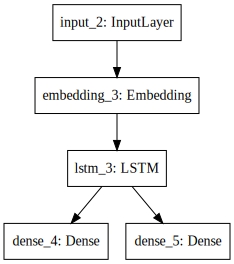

In [51]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# Functional Model
inputs = Input(shape=(input_length,))

embed = Embedding(vocab_size, 10, input_length=input_length)(inputs)
lstm = LSTM(10)(embed)
word_pred = Dense(vocab_size, activation='softmax')(lstm)
# I think we have 90 categories
category_preds = Dense(90, activation = "sigmoid")(lstm)

#predictions = concatenate([word_pred, category_preds])

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=[word_pred, category_preds])
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [52]:
y = np.concatenate((y, y_categories), axis=1)

In [54]:
model.fit(X, [y, y_categories], epochs=1)

ValueError: Error when checking target: expected dense_4 to have shape (None, 6568) but got array with shape (351162, 6658)